# How do we model the impact of increasing member retention on churn to estimate projected membership growth? 

## Import some things

In [1]:
from scipy import stats
from scipy.optimize import curve_fit
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import numpy as np
from myst_nb import glue

In [2]:
plt.style.use('seaborn-poster')

Make some convenient functions for plotting

## What's the impact of decreasing the churn rate? 

Next let's assume a basic mass balance of membership and that there exists a static fraction of members who are eligble for this program $f_{prog}$. Let's assume that the kinetics of members going into this program is roughly equivalent to a known membership fraction per year. 

1. Mass balance of members
$$ \frac{d C_{mem}}{dt} = Q_{new}(t)  - k_{churn}\cdot C_{avail} - k_{churn,prog}\cdot C_{prog}$$

2. Mass balance of members available to the program
$$ \frac{d C_{avail}}{dt} = Q_{new}(t) - k_{avail \rightarrow prog}\cdot C_{avail}\cdot f_{prog} +k_{prog \rightarrow avail}\cdot C_{prog} - k_{churn}\cdot C_{avail} - k_{churn,prog}\cdot C_{prog}$$

3. Mass balance of members in program
$$ \frac{d C_{prog}}{dt} = k_{avail \rightarrow prog}\cdot C_{avail}\cdot f_{prog} - k_{prog \rightarrow avail}\cdot C_{prog}- k_{churn,prog}\cdot C_{prog}$$


Let's set all the kinetics we need. In a _really_ simple case, we can assume a basic, first order increase/decrease using the following equation, which is really the analytical solution re-arranging the e^-kt in a common sense way.  

$$ k = -\frac{ln(1-\%)}{365~days}$$

In [3]:
# 10% of members eligible for program
f_prog = 0.05 

# 50% of members of eligible members exposed to the program will enroll (200k max)
k_avail_prog =-np.log(1-0.5)/365

# 5% of members will 'drop out' in a given year, on a 1/d basis
k_prog_avail = -np.log(1-0.05)/365 

# 50% of members churn in a given year
k_churn = -np.log(1-0.5)/365 

# 10% # % impact to member churn from the program
f_incremental_churn_decrease = 0.1

# new churn rate for program in 1/d
k_churn_prog = -np.log(1-(0.1*(1-f_incremental_churn_decrease)))/365 

# inflow of members
Q_in = 10_000 / 365

# total membership at start
V_start = 11_000

# members in the program at start
program_start = 1_000

Let's turn the diffeqs above into code. 

In [4]:
def model(z, t):
    d0dt = Q_in - k_churn*z[1] - k_churn_prog*z[2] 
        # total book membership:
            # Influent: membership inflow
            # Effluent: churn of members outside program and churn of members inside program)
        
    d1dt = Q_in - k_avail_prog*z[1] * f_prog + k_prog_avail*z[2]  - k_churn*z[1] - k_churn_prog*z[2]
        # total membership available to program
            # Influent: membership inflow and people dropping out of the program
            # Effluent: people moving to program (of the fraction available), churn of members outside program, churn of members inside program 
        
    d2dt = k_avail_prog*z[1]* f_prog - k_prog_avail*z[2] - k_churn_prog*z[2]
        # total membership in the program
            # Influent: membership inflow 
            # Effluent: people moving back to membership and churn of members inside program 
            
    dzdt = [d0dt, d1dt,d2dt]
    return dzdt

In [5]:
# initial condition
z0 = [V_start, V_start-program_start, program_start]
# time points
t = np.linspace(0, 365*2, num = 365*2)
# solve ODE
z = odeint(model, z0, t)
t = t/365

Let's do some plotting. 

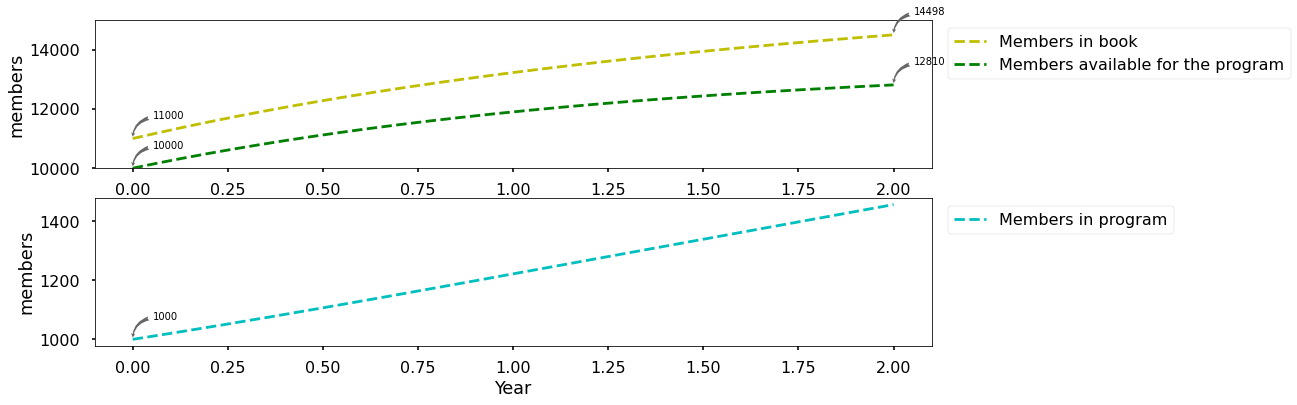

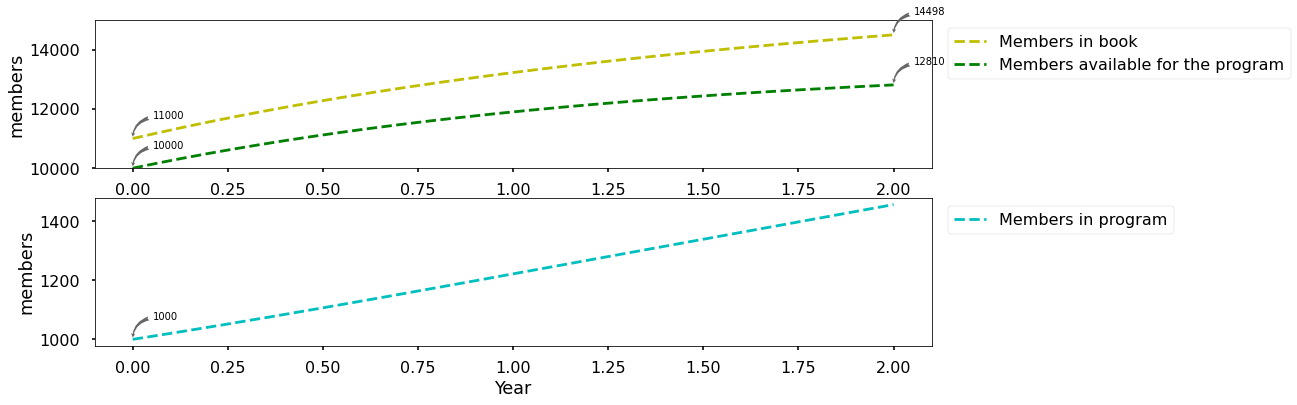

In [6]:
fig, axs = plt.subplots(2, 1,figsize=(15,6))
axs[0].plot(t, z[:, 0], 'y--', label = r'Members in book')
axs[0].plot(t, z[:, 1], 'g--', label = r'Members available for the program')
axs[0].set_ylabel('members')

axs[0].annotate(f'{z[-1,0]:.0f}', xy=(t[-1], z[-1,0]),  xycoords='data',
            xytext=(20, 20), textcoords='offset points',
            arrowprops=dict(arrowstyle="fancy",
                            fc="0.4", ec="none",
                            connectionstyle="angle3,angleA=0,angleB=-90"))

axs[0].annotate(f'{z[0,0]:.0f}', xy=(t[0], z[0,0]),  xycoords='data',
            xytext=(20, 20), textcoords='offset points',
            arrowprops=dict(arrowstyle="fancy",
                            fc="0.4", ec="none",
                            connectionstyle="angle3,angleA=0,angleB=-90"))
axs[0].legend(bbox_to_anchor=(1.01, 1), loc='upper left', ncol=1)
axs[0].set_ylim([1e4,1.5e4])

axs[0].annotate(f'{z[-1,1]:.0f}', xy=(t[-1], z[-1,1]),  xycoords='data',
            xytext=(20, 20), textcoords='offset points',
            arrowprops=dict(arrowstyle="fancy",
                            fc="0.4", ec="none",
                            connectionstyle="angle3,angleA=0,angleB=-90"))

axs[0].annotate(f'{z[0,1]:.0f}', xy=(t[0], z[0,1]),  xycoords='data',
            xytext=(20, 20), textcoords='offset points',
            arrowprops=dict(arrowstyle="fancy",
                            fc="0.4", ec="none",
                            connectionstyle="angle3,angleA=0,angleB=-90"))


axs[1].plot(t, z[:,2], 'c--', label = f'Members in program')
axs[1].set_ylabel('members')
axs[1].legend(bbox_to_anchor=(1.01, 1), loc='upper left', ncol=1)
axs[1].annotate(f'{z[0,2]:.0f}', xy=(t[0], z[0,2]),  xycoords='data',
            xytext=(20, 20), textcoords='offset points',
            arrowprops=dict(arrowstyle="fancy",
                            fc="0.4", ec="none",
                            connectionstyle="angle3,angleA=0,angleB=-90"))
axs[1].set_xlabel('Year')

glue("massbalance-churn-w-program", fig, display=False)

In [7]:
wprogram_total_book = z[-1,0]
wprogram_total_prog = z[-1,2]

glue("wprogram_total_book",f'{z[-1,0]:.0f}')
glue("wprogram_total_prog",f'{z[-1,2]:.0f}')


'14498'

'1457'

In [8]:
# 10% of members eligible for program
f_prog = 0.00

# 50% of members of eligible members exposed to the program will enroll (200k max)
k_avail_prog =0

# 5% of members will 'drop out' in a given year, on a 1/d basis
k_prog_avail = 0

# 50% of members churn in a given year
k_churn = -np.log(1-0.5)/365 

# 10% # % impact to member churn from the program
f_incremental_churn_decrease = 0.0

# new churn rate for program in 1/d
k_churn_prog = 0

# inflow of members
Q_in = 10_000 / 365

# total membership at start
V_start = 11_000

# members in the program at start
program_start = 0

In [9]:
# initial condition
z0 = [V_start, V_start-program_start, program_start]
# time points
t = np.linspace(0, 365*2, num = 365*2)
# solve ODE
z = odeint(model, z0, t)
t = t/365

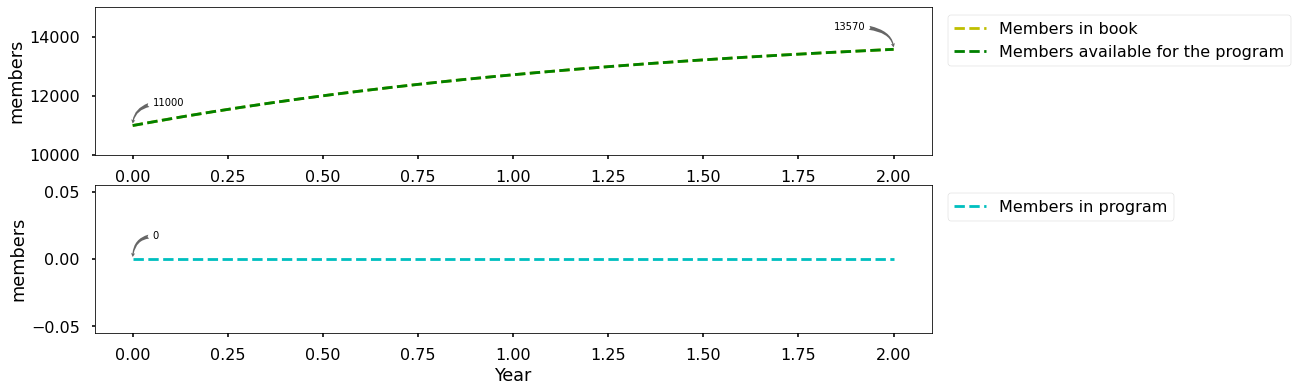

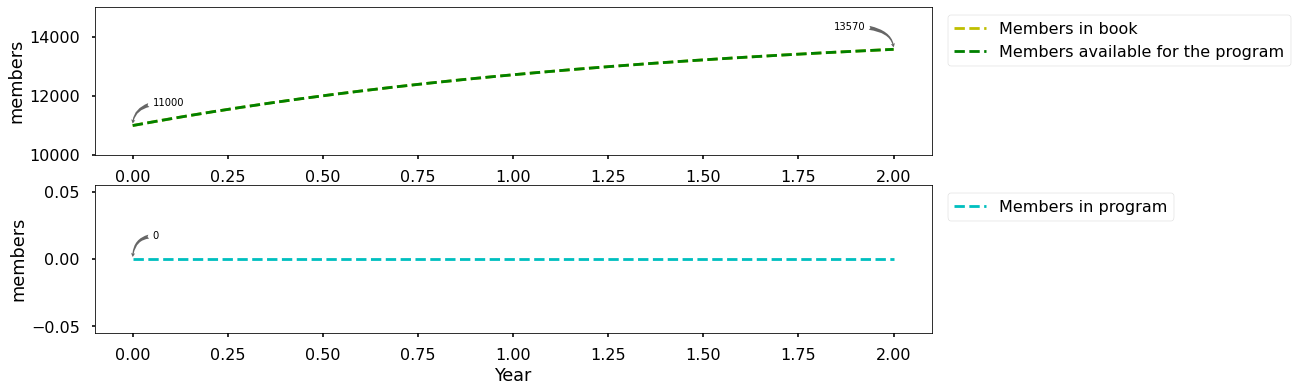

In [10]:
fig, axs = plt.subplots(2, 1,figsize=(15,6))
axs[0].plot(t, z[:, 0], 'y--', label = r'Members in book')
axs[0].plot(t, z[:, 1], 'g--', label = r'Members available for the program')
axs[0].set_ylabel('members')

axs[0].annotate(f'{z[-1,0]:.0f}', xy=(t[-1], z[-1,0]),  xycoords='data',
            xytext=(-60, 20), textcoords='offset points',
            arrowprops=dict(arrowstyle="fancy",
                            fc="0.4", ec="none",
                            connectionstyle="angle3,angleA=0,angleB=-90"))

axs[0].annotate(f'{z[0,0]:.0f}', xy=(t[0], z[0,0]),  xycoords='data',
            xytext=(20, 20), textcoords='offset points',
            arrowprops=dict(arrowstyle="fancy",
                            fc="0.4", ec="none",
                            connectionstyle="angle3,angleA=0,angleB=-90"))
axs[0].legend(bbox_to_anchor=(1.01, 1), loc='upper left', ncol=1)
axs[0].set_ylim([1e4,1.5e4])


axs[1].plot(t, z[:,2], 'c--', label = f'Members in program')
axs[1].set_ylabel('members')
axs[1].legend(bbox_to_anchor=(1.01, 1), loc='upper left', ncol=1)
axs[1].annotate(f'{z[0,2]:.0f}', xy=(t[0], z[0,2]),  xycoords='data',
            xytext=(20, 20), textcoords='offset points',
            arrowprops=dict(arrowstyle="fancy",
                            fc="0.4", ec="none",
                            connectionstyle="angle3,angleA=0,angleB=-90"))
axs[1].set_xlabel('Year')
glue("massbalance-churn-wo-program", fig, display = False)

In [11]:
woprogram_total_book = z[-1,0]
woprogram_total_prog = z[-1,2]

glue("woprogram_total_book",f'{z[-1,0]:.0f}')
glue("woprogram_total_prog",f'{z[-1,2]:.0f}')


'13570'

'0'

In [12]:
glue("incremental_program_membership_total",f'{wprogram_total_book - woprogram_total_book:.0f}')
glue("incremental_program_membership_fraction",f'{((wprogram_total_book/woprogram_total_book-1) *100):.1f}%')
glue("incremental_program_membership_growth",f'{100*((wprogram_total_book - V_start)/ (woprogram_total_book - V_start)-1):.1f}%')

'927'

'6.8%'

'36.1%'

## What if we ran it for 10 years?

In [13]:
# 10% of members eligible for program
f_prog = 0.05 

# 50% of members of eligible members exposed to the program will enroll (200k max)
k_avail_prog =-np.log(1-0.5)/365

# 5% of members will 'drop out' in a given year, on a 1/d basis
k_prog_avail = -np.log(1-0.05)/365 

# 50% of members churn in a given year
k_churn = -np.log(1-0.5)/365 

# 10% # % impact to member churn from the program
f_incremental_churn_decrease = 0.1

# new churn rate for program in 1/d
k_churn_prog = -np.log(1-(0.1*(1-f_incremental_churn_decrease)))/365 

# inflow of members
Q_in = 10_000 / 365

# total membership at start
V_start = 11_000

# members in the program at start
program_start = 1_000

In [14]:
# initial condition
z0 = [V_start, V_start-program_start, program_start]
# time points
t = np.linspace(0, 365*10, num = 365*10)
# solve ODE
z = odeint(model, z0, t)
t = t/365

Let's do some plotting. 

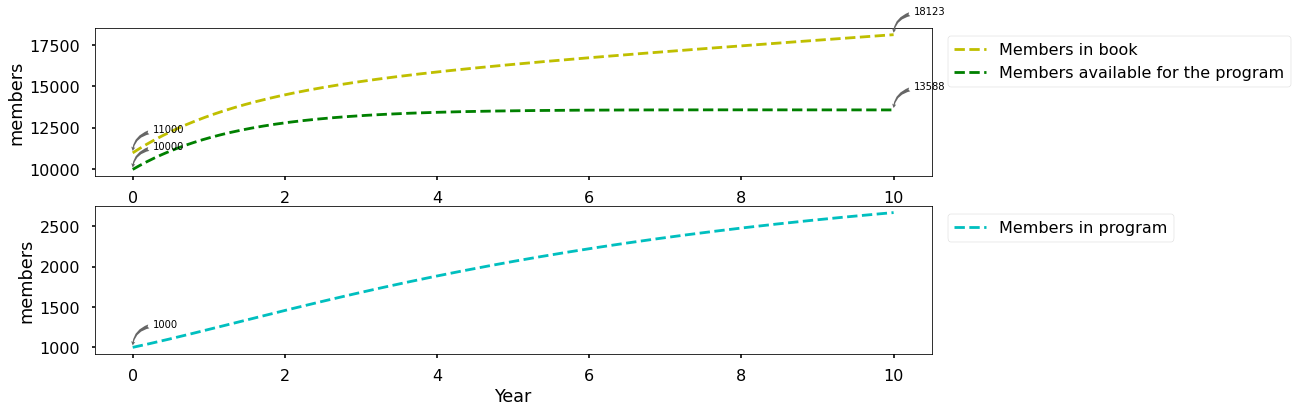

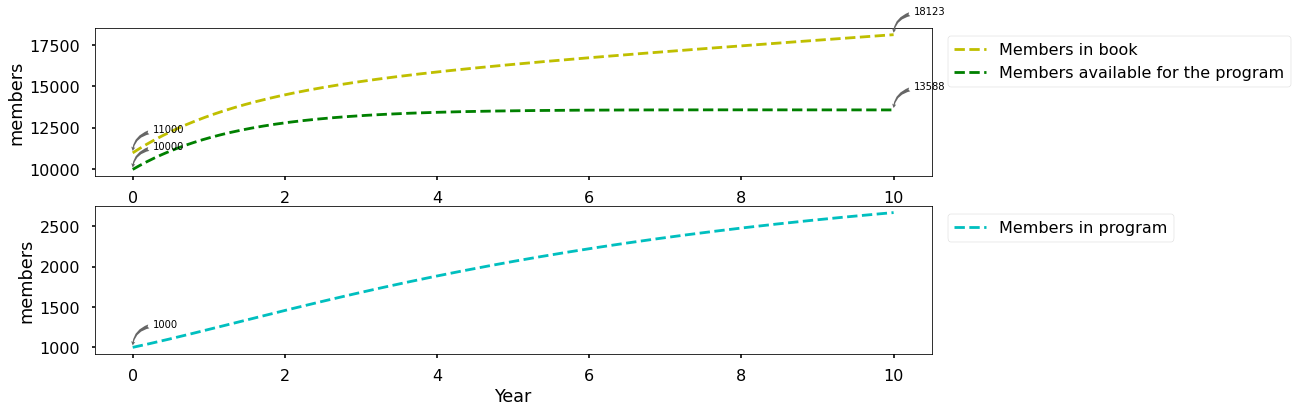

In [15]:
fig, axs = plt.subplots(2, 1,figsize=(15,6))
axs[0].plot(t, z[:, 0], 'y--', label = r'Members in book')
axs[0].plot(t, z[:, 1], 'g--', label = r'Members available for the program')
axs[0].set_ylabel('members')

axs[0].annotate(f'{z[-1,0]:.0f}', xy=(t[-1], z[-1,0]),  xycoords='data',
            xytext=(20, 20), textcoords='offset points',
            arrowprops=dict(arrowstyle="fancy",
                            fc="0.4", ec="none",
                            connectionstyle="angle3,angleA=0,angleB=-90"))

axs[0].annotate(f'{z[0,0]:.0f}', xy=(t[0], z[0,0]),  xycoords='data',
            xytext=(20, 20), textcoords='offset points',
            arrowprops=dict(arrowstyle="fancy",
                            fc="0.4", ec="none",
                            connectionstyle="angle3,angleA=0,angleB=-90"))
axs[0].legend(bbox_to_anchor=(1.01, 1), loc='upper left', ncol=1)
# axs[0].set_ylim([1e4,1.5e4])

axs[0].annotate(f'{z[-1,1]:.0f}', xy=(t[-1], z[-1,1]),  xycoords='data',
            xytext=(20, 20), textcoords='offset points',
            arrowprops=dict(arrowstyle="fancy",
                            fc="0.4", ec="none",
                            connectionstyle="angle3,angleA=0,angleB=-90"))

axs[0].annotate(f'{z[0,1]:.0f}', xy=(t[0], z[0,1]),  xycoords='data',
            xytext=(20, 20), textcoords='offset points',
            arrowprops=dict(arrowstyle="fancy",
                            fc="0.4", ec="none",
                            connectionstyle="angle3,angleA=0,angleB=-90"))


axs[1].plot(t, z[:,2], 'c--', label = f'Members in program')
axs[1].set_ylabel('members')
axs[1].legend(bbox_to_anchor=(1.01, 1), loc='upper left', ncol=1)
axs[1].annotate(f'{z[0,2]:.0f}', xy=(t[0], z[0,2]),  xycoords='data',
            xytext=(20, 20), textcoords='offset points',
            arrowprops=dict(arrowstyle="fancy",
                            fc="0.4", ec="none",
                            connectionstyle="angle3,angleA=0,angleB=-90"))
axs[1].set_xlabel('Year')

glue("massbalance-churn-w-program-decade", fig, display = False)